# Start working on a standalone autoencoder class

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

## Model definition

This is a simplified architecture where many features that were possible in Aiden's code were cut out because I think they were not in use for the final model.

We can add these back in later.

In [2]:
class PreConvBlock(nn.Module):
    def __init__(self, 
                 in_channels = 1, 
                 out_channels = 16, 
                 kernel = 3, 
                 stride=1, 
                 pool_size = 2,
                 use_batch_norm = False):
        """
        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            stride (int): Stride for the convolutional layers.
        """
        super(PreConvBlock, self).__init__()
        
        self.layers = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, 
                      kernel_size=kernel, stride=stride, 
                      padding=(kernel - stride) // 2, 
                      bias= not use_batch_norm),
        ])
        if use_batch_norm:
            self.layers.append(nn.BatchNorm2d(out_channels))
        
        self.layers.append(nn.ReLU(inplace=True))
        self.layers.append(nn.MaxPool2d(kernel_size=pool_size))
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
class ResidualBlock(nn.Module):
    def __init__(self, 
                 n_channels = 16, 
                 kernel = 3, 
                 stride = 1, 
                 use_batch_norm = False, 
                 downsample=None,
                 pool_size = 4,
                 n_layers = 3):
        """
        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            stride (int): Stride for the convolutional layers.
            downsample (nn.Module, optional): Downsampling layer if input and output dimensions differ.
        """
        super(ResidualBlock, self).__init__()
        
        self.layers = nn.ModuleList()
        for i_layer in range(n_layers):
            self.layers.append(nn.Conv2d(n_channels, n_channels, 
                                          kernel_size=kernel, stride=stride, 
                                          padding=(kernel - stride) // 2, 
                                          bias= not use_batch_norm))
            if use_batch_norm:
                self.layers.append(nn.BatchNorm2d(n_channels))
            if i_layer!=(n_layers - 1):
                self.layers.append(nn.ReLU(inplace=True))
        
        self.downsample = downsample  # Optional downsampling layer
        self.post_residual_layers = nn.ModuleList([nn.ReLU(inplace=True)])
        if pool_size is not None:
            self.post_residual_layers.append(nn.MaxPool2d(kernel_size=pool_size))
    
    def forward(self, x):
        identity = x

        # Pass through the layers in the ModuleList
        for layer in self.layers:
            x = layer(x)

        # Apply downsampling to the identity if necessary
        if self.downsample:
            identity = self.downsample(identity)

        # Add the residual connection
        x += identity
        for layer in self.post_residual_layers:
            x = layer(x)

        return x
    
class Encoder(nn.Module):

    def __init__(self, 
                 configs):
        """
        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            stride (int): Stride for the convolutional layers.
        """
        super(Encoder, self).__init__()
        
        self.configs = configs

        self.residual_layers = nn.ModuleList()

        for i_blocks in range(configs['num_blocks']):
            self.residual_layers.append(PreConvBlock(configs['in_channels_%d'%i_blocks],
                                            configs['out_channels_%d'%i_blocks],
                                            configs['kernel_preconv'],
                                            configs['stride_preconv'],
                                            configs['pool_size_preconv_%d'%i_blocks],
                                            configs['use_batch_norm_preconv']))
            self.residual_layers.append(ResidualBlock(configs['out_channels_%d'%i_blocks],
                                             configs['kernel_residual'],
                                             configs['stride_residual'],
                                             configs['use_batch_norm_residual'],
                                             pool_size=configs['pool_size_residual_%d'%i_blocks],
                                             n_layers=configs['n_layers_residual']))
            
        self.linear_layers = nn.ModuleList([nn.Linear(configs['out_conv'], configs['out_linear'], bias = not configs['use_batch_norm_linear']),])
        if configs['use_batch_norm_linear']:
            self.linear_layers.append(nn.BatchNorm1d(configs['out_linear']))
        self.linear_layers.append(nn.ReLU(inplace=True))
        self.linear_layers.append(nn.Linear(configs['out_linear'], configs['embed_size']))

    def forward(self, x):
        bs, seq_length, c, h ,w = x.size()
        
        x = x.view(bs*seq_length, c, h, w)
        for layer in self.residual_layers:
            x = layer(x)
        
        x = x.view(bs*seq_length, -1)
        for layer in self.linear_layers:
            x = layer(x)
        
        x = x.view(bs, seq_length, -1)
        return x

In [3]:
class SingleSessionDecoder(nn.Module):
    def __init__(self, configs):
        super(SingleSessionDecoder, self).__init__()
        self.configs = configs
        self.linear_layer = nn.Linear(configs['embed_size'], configs['image_height']*configs['image_width'])

    def forward(self, x):
        bs, seq_length, _ = x.size()
        x = self.linear_layer(x)
        x = x.view(bs, seq_length, 1, self.configs['image_height'], self.configs['image_width'])
        return x

In [4]:
class AutoEncoder(nn.Module):
    def __init__(self, configs):
        super(AutoEncoder, self).__init__()
        self.configs = configs
        self.encoder = Encoder(configs)
        self.decoder = SingleSessionDecoder(configs)
    
    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x, z

### Default configs

I think these correspond to the architecture of the single-session autoencoders that Aiden used but will have to doublecheck this.

In [7]:
configs = {
    'num_blocks': 2,
    'in_channels_0': 1,
    'out_channels_0': 16,
    'in_channels_1': 16,
    'out_channels_1': 32,
    'kernel_preconv': 3,
    'stride_preconv': 1,
    'pool_size_preconv_0': 2,
    'pool_size_preconv_1': 4,
    'use_batch_norm_preconv': False,
    'kernel_residual': 3,
    'stride_residual': 1,
    'use_batch_norm_residual': False,
    'pool_size_residual_0': None,
    'pool_size_residual_1': 4,
    'n_layers_residual': 3,
    'out_conv': 288,
    'out_linear': 128,
    'embed_size': 16,
    'use_batch_norm_linear': False,
    'image_height': 120,
    'image_width': 112
}

## Trying it out

In [8]:
AE = AutoEncoder(configs)

In [9]:
AE

AutoEncoder(
  (encoder): Encoder(
    (residual_layers): ModuleList(
      (0): PreConvBlock(
        (layers): ModuleList(
          (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
          (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
      )
      (1): ResidualBlock(
        (layers): ModuleList(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
          (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU(inplace=True)
          (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (post_residual_layers): ModuleList(
          (0): ReLU(inplace=True)
        )
      )
      (2): PreConvBlock(
        (layers): ModuleList(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
          

#### Load some example images
These are from a single trial and have been preprocessed to be the required format.

In [13]:
example_images = np.load('example_images.npy')
print(example_images.shape)

(5, 120, 112)


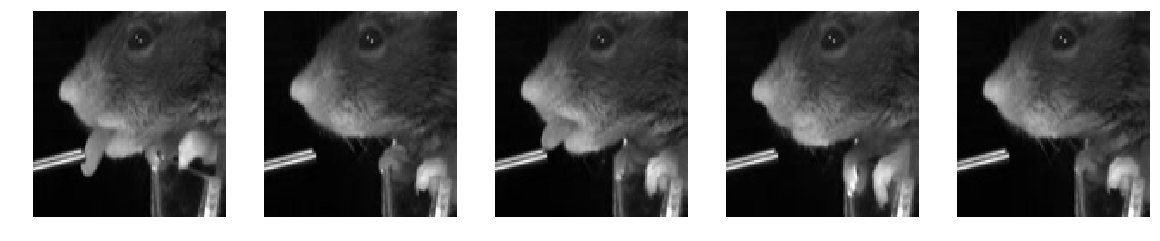

In [14]:
plt.subplots(1,5, figsize=(20, 4))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(example_images[i,], cmap='gray')
    plt.axis('off')

### Baby training loop

In [15]:
optimizer = torch.optim.Adam(AE.parameters(), lr=1e-3)

loss_fn = nn.MSELoss()

n_epochs = 1000

for epoch in range(n_epochs):
    optimizer.zero_grad()
    x_hat, z = AE.forward(torch.tensor(example_images).float().view(5,1,1,120,112))
    loss = loss_fn(x_hat.squeeze(), torch.tensor(example_images).float())
    loss.backward()
    optimizer.step()
    if epoch%100 == 99: print(epoch, loss.item())

99 0.005644149612635374
199 0.004700484219938517
299 0.004684308543801308
399 0.004642024170607328
499 0.004142893943935633
599 0.0026221880689263344
699 0.0019655004143714905
799 0.0017494469648227096
899 0.001485453569330275
999 0.0011165253818035126


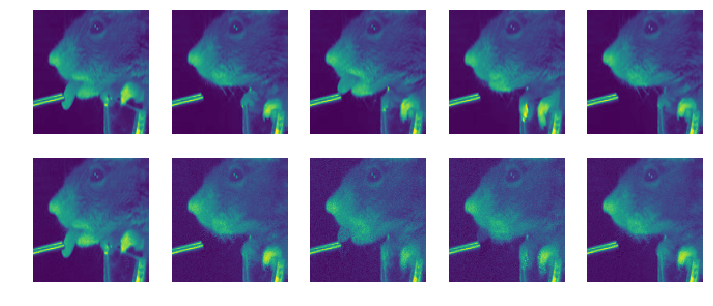

In [17]:
with torch.no_grad():
    img_hat, z = AE.forward(torch.tensor(example_images).float().view(5,1,1,120,112))
plt.subplots(2,5,figsize=(12,5))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.imshow(example_images[i])
    plt.axis('off')
    plt.subplot(2,5,i+6)
    plt.imshow(img_hat.squeeze().detach().numpy()[i])
    plt.axis('off')